In [1]:
#imports
import cv2
import numpy as np
import pandas as pd
import os
import random
import keras
import tensorflow as tf
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir
from PIL import Image as PImage
import matplotlib.pyplot as plt
import pydot
from pconv_layer import PConv2D
from sklearn.model_selection import train_test_split

In [2]:
class createAugment(keras.utils.Sequence):
    # Generates masked_image, masks, and target images for training
    def __init__(self, X, y, batch_size=32, dim=(32, 32),
       n_channels=3, shuffle=True):
        # Initialize the constructor
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X_inputs, y_output = self._data_generation(indexes)
        return X_inputs, y_output

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    
    def _createMask(self, img):
        ## Prepare masking matrix
        mask = np.full((32,32,3), 255, np.uint8) ## White background
        for _ in range(np.random.randint(1, 10)):
            # Get random x locations to start line
            x1, x2 = np.random.randint(1, 32), np.random.randint(1, 32)
            # Get random y locations to start line
            y1, y2 = np.random.randint(1, 32), np.random.randint(1, 32)
            # Get random thickness of the line drawn
            thickness = np.random.randint(1, 3)
            # Draw black line on the white mask
            cv2.line(mask,(x1,y1),(x2,y2),(0,0,0),thickness)
        ## Mask the image
        masked_image = img.copy()
        masked_image[mask==0] = 255
        return masked_image, mask
    
    def _data_generation(self, idxs):
        # Masked_images is a matrix of masked images used as input
        Masked_images = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
        # Mask_batch is a matrix of binary masks used as input
        Mask_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Binary Masks
        # y_batch is a matrix of original images used for computing error from reconstructed image
        y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

        ## Iterate through random indexes
        for i, idx in enumerate(idxs):
            image_copy = self.X[idx].copy()
            ## Get mask associated to that image
            masked_image, mask = self._createMask(image_copy)

            ## Append and scale down.
            Masked_images[i,] = masked_image/255
            Mask_batch[i,] = mask/255
            y_batch[i] = self.y[idx]/255

        return [Masked_images, Mask_batch], y_batch

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [4]:
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(PredictionLogger, self).__init__()

    # The callback will be executed after an epoch is completed
    def on_epoch_end(self, logs, epoch):
        # Pick a batch, and sample the masked images, masks, and the labels
        sample_idx = 54
        [masked_images, masks], sample_labels = testgen[sample_idx]  

        # Initialize empty lists store intermediate results
        m_images = []
        binary_masks = []
        predictions = []
        labels = []

        # Iterate over the batch
        for i in range(32):
            # Our inpainting model accepts masked imaged and masks as its inputs,
            # then use perform inference
            inputs = [B]
            impainted_image = model.predict(inputs)

            # Append the results to the respective lists
            m_images.append(masked_images[i])
            binary_masks.append(masks[i])
            predictions.append(impainted_image.reshape(impainted_image.shape[1:]))
            labels.append(sample_labels[i])

        # Log the results on wandb run page and voila!
        wandb.log({"masked_images": [wandb.Image(m_image)
                             for m_image in m_images]})
        wandb.log({"masks": [wandb.Image(mask)
                             for mask in binary_masks]})
        wandb.log({"predictions": [wandb.Image(inpainted_image)
                             for inpainted_image in predictions]})
        wandb.log({"labels": [wandb.Image(label)
                             for label in labels]})
        
    def prepare_model(self, input_size=(32,32,3)):
        input_image = keras.layers.Input(input_size)
        input_mask = keras.layers.Input(input_size)

        conv1, mask1, conv2, mask2 = self.__encoder_layer(32, input_image, input_mask)
        conv3, mask3, conv4, mask4 = self.__encoder_layer(64, conv2, mask2)
        conv5, mask5, conv6, mask6 = self.__encoder_layer(128, conv4, mask4)
        conv7, mask7, conv8, mask8 = self.__encoder_layer(256, conv6, mask6)

        conv9, mask9, conv10, mask10 = self.__decoder_layer(256, 128, conv8, mask8, conv7, mask7)
        conv11, mask11, conv12, mask12 = self.__decoder_layer(128, 64, conv10, mask10, conv5, mask5)
        conv13, mask13, conv14, mask14 = self.__decoder_layer(64, 32, conv12, mask12, conv3, mask3)
        conv15, mask15, conv16, mask16 = self.__decoder_layer(32, 3, conv14, mask14, conv1, mask1)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv16)

        return keras.models.Model(inputs=[input_image, input_mask], outputs=[outputs])  
    
    def __encoder_layer(self, filters, in_layer, in_mask):
        conv1, mask1 = PConv2D(32, (3,3), strides=1, padding='same')([in_layer, in_mask])
        conv1 = keras.activations.relu(conv1)

        conv2, mask2 = PConv2D(32, (3,3), strides=2, padding='same')([conv1, mask1])
        conv2 = keras.layers.BatchNormalization()(conv2, training=True)
        conv2 = keras.activations.relu(conv2)

        return conv1, mask1, conv2, mask2

    def __decoder_layer(self, filter1, filter2, in_img, in_mask, share_img, share_mask):
        up_img = keras.layers.UpSampling2D(size=(2,2))(in_img)
        up_mask = keras.layers.UpSampling2D(size=(2,2))(in_mask)
        concat_img = keras.layers.Concatenate(axis=3)([share_img, up_img])
        concat_mask = keras.layers.Concatenate(axis=3)([share_mask, up_mask])

        conv1, mask1 = PConv2D(filter1, (3,3), padding='same')([concat_img, concat_mask])
        conv1 = keras.activations.relu(conv1)

        conv2, mask2 = PConv2D(filter2, (3,3), padding='same')([conv1, mask1])
        conv2 = keras.layers.BatchNormalization()(conv2)
        conv2 = keras.activations.relu(conv2)

        return conv1, mask1, conv2, mask2

In [5]:
class inpaintingModel:
    '''
    Build UNET like model for image inpaining task.
    '''
    def prepare_model(self, input_size=(32,32,3)):
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
        conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
        conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 

        conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv9)

        return keras.models.Model(inputs=[inputs], outputs=[outputs])  

    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

Lets test a few functions first:

In [6]:
#lets start with __createMask(self, img)
path_training_org= 'C:/Users/pnk72/Downloads/CDGI-project/TrainingData3232/Original'
photos=os.listdir(path_training_org)

In [7]:
image = cv2.imread(path_training_org+'\\'+ photos[0])

In [8]:
#show image
cv2.imshow('image',image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
def loadImages(path):
    # return array of images
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = cv2.imread(path_training_org+'\\'+ image)
        loadedImages.append(img)
    return loadedImages

In [10]:
data = loadImages(path_training_org)

In [11]:
augment = createAugment(data,data)

In [12]:
augment.__len__()

93

In [13]:
augment.on_epoch_end()

In [14]:
masked_image, mask = augment._createMask(image)
print(len(masked_image))
print(len(mask))
print(len(mask[0]))

32
32
32


In [15]:
[Masked_images, Mask_batch], y_batch = augment._data_generation([0,1,2,3])

In [16]:
print(len(y_batch))
print(len(y_batch[0]))
print(len(y_batch[0][0]))

32
32
32


In [17]:
predlog = PredictionLogger()
model = predlog.prepare_model()

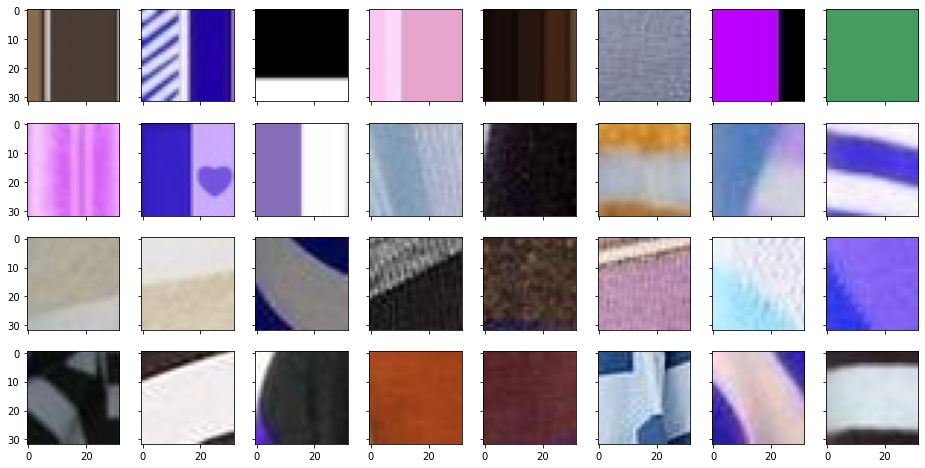

In [18]:
sample_images = data[100:132]
#sample_labels = y_train[:32]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

In [19]:
x_train,x_test,y_train,y_test=train_test_split(data,data,test_size=0.2)

In [20]:
traingen = createAugment(x_train, y_train)
testgen = createAugment(x_test, y_test, shuffle=False)

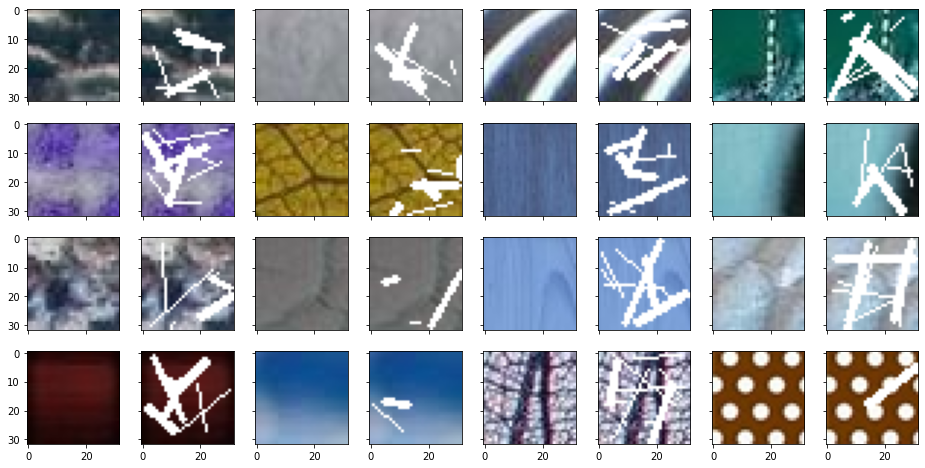

In [21]:
#attention - it is pretty weird. In the original implementation there is just sample_masks instead of sample_masks[0], 
#however, I was not able to figure out why this is happening atm. We should put some effort in this shit, probably we gonna 
#have more problems because of this later
#but i am not 100% sure. maybe they were just wrong but cant imagine
#anyways: sample_masks[0] gives us the mask applied to the photo, while sample_masks[1] just returns the masks

## Examples
sample_idx = 2 ## Change this to see different batches

sample_masks, sample_labels = traingen[sample_idx]
sample_images = [None]*(len(sample_masks[0])+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks[0]

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image)

plt.show()

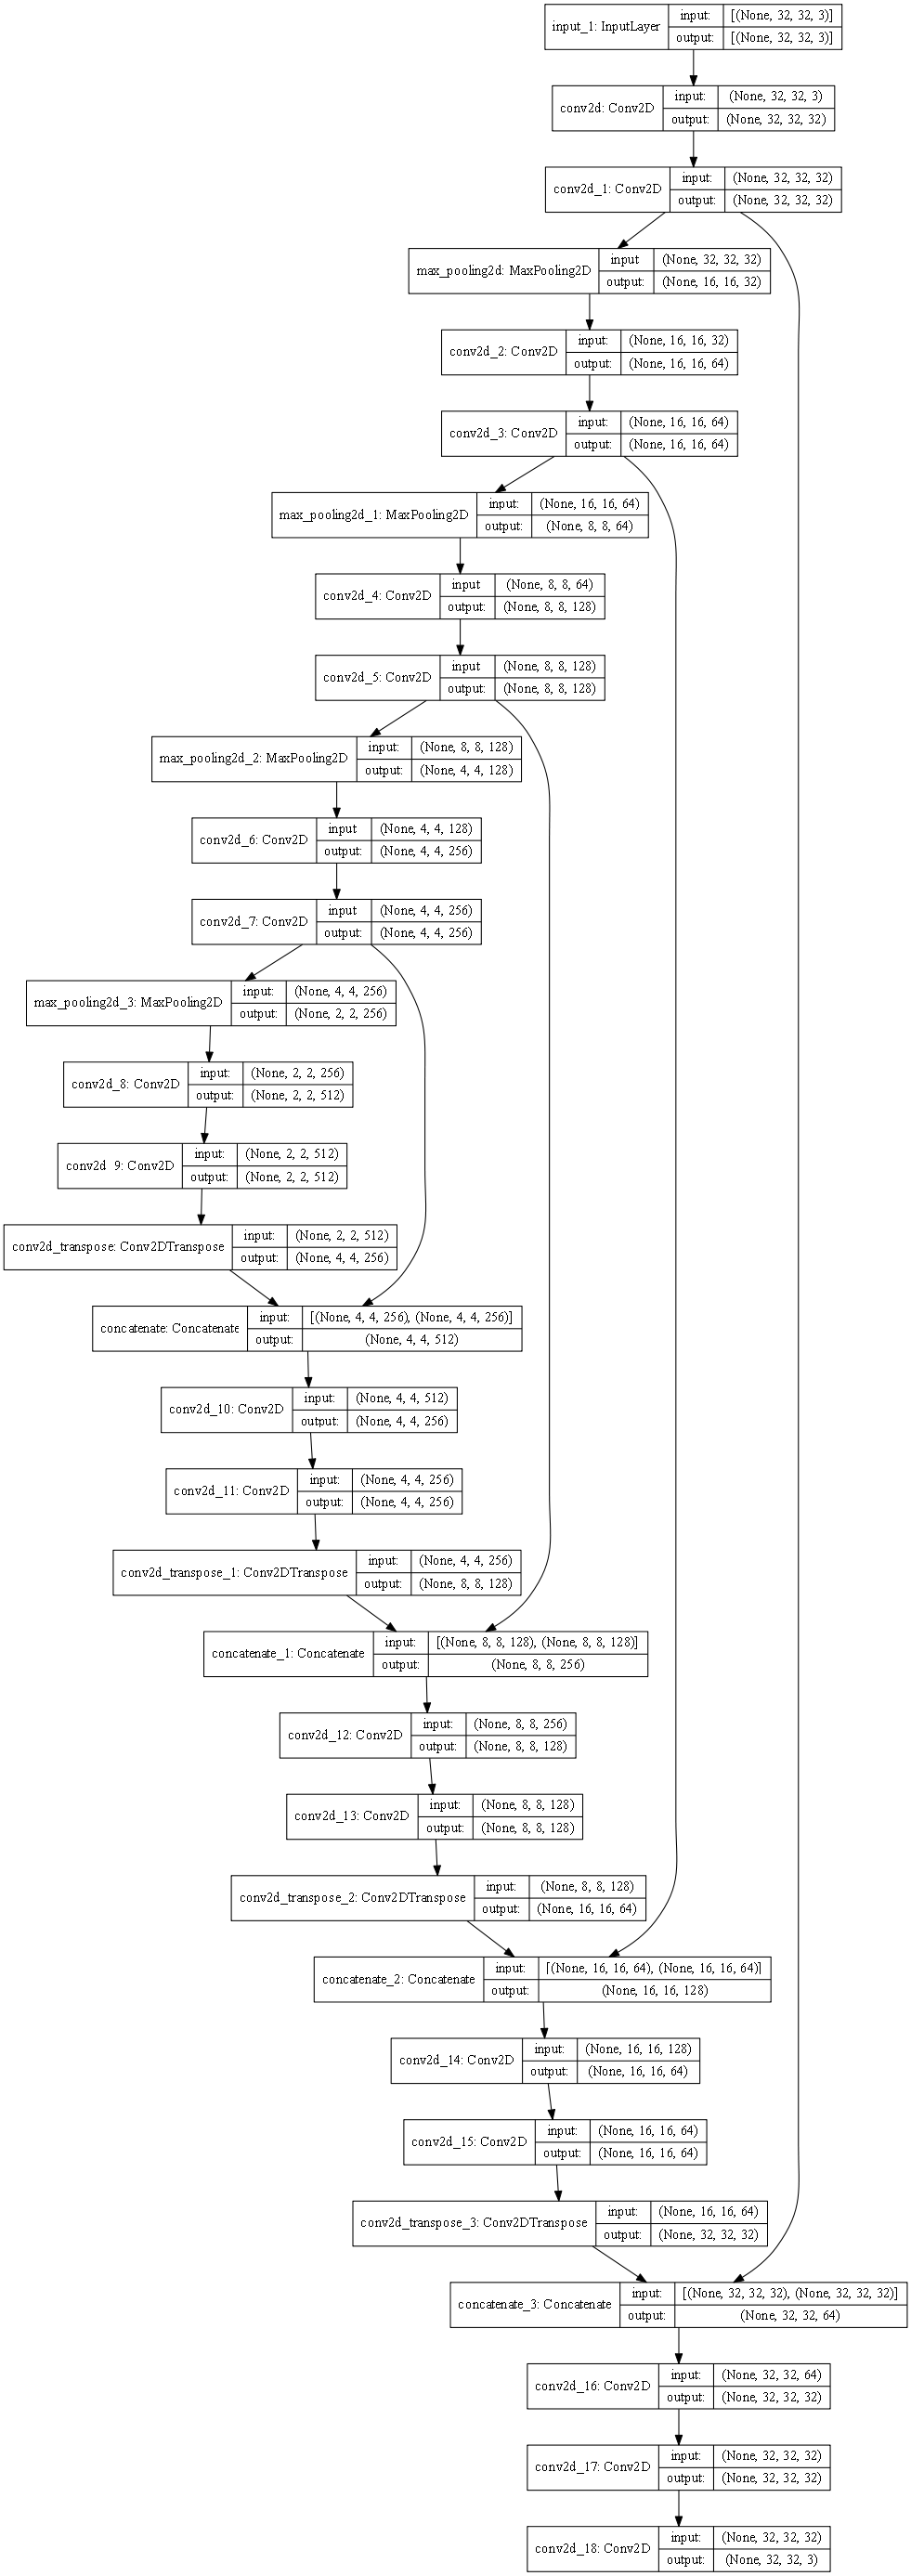

In [22]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[dice_coef])
keras.utils.plot_model(model, show_shapes=True, dpi=76, to_file='model_v1.png')